# Training a RoBERTa Language Model

In this notebook we train a RoBERTa language model on the IMSLP and/or target data.  This code can be used to train two different language models: (a) one that is trained on target data, and (b) one that is trained on IMSLP data and finetuned on target data.  For (a), you can stop at the end of the section entitled "Train Language Model".

Note that this notebook needs to be run in a different virtual environment from previous notebooks because it requires a different version of the transformers library than is used by the fastai library.  This environment is specified in requirements_lm.txt.

In [1]:
%matplotlib inline

In [17]:
from pathlib import Path
import json
from train_utils import plotLosses
import transformers

In [3]:
bpe_path = Path('/home/dyang/.fastai/data/bscore_lm/bpe_data')
bpe_path.mkdir(exist_ok=True, parents=True)

### Train Language Model

In [10]:
data_type = 'imslp' # 'target' or 'imslp'

In [26]:
lm_train_file = bpe_path/f'bpe_lm_{data_type}_train-augmented.txt'
lm_valid_file = bpe_path/f'bpe_lm_{data_type}_valid-augmented.txt'
tok_path = bpe_path/f'tokenizer_{data_type}'
output_model_path = bpe_path/f'models/roberta_train-{data_type}_lm-augmented'

In [27]:
# changes from defaults:
# vocab_size: 30522 -> 30000
# num_hidden_layers: 12 -> 6
# max_position_embeddings: 512 -> 514 (or 258)
# type_vocab_size: 2 -> 1
# layer_norm_eps: 1e-12 -> 1e-5
config = {
    "architectures": [
        "RobertaForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "initializer_range": 0.02,
    "intermediate_size": 3072,
    "layer_norm_eps": 1e-05,
    "max_position_embeddings": 514,
    "model_type": "roberta",
    "num_attention_heads": 12,
    "num_hidden_layers": 6,
    "type_vocab_size": 1,
    "vocab_size": 30000
    }

In [28]:
with open(f"{tok_path}/config.json", 'w') as fp:
    json.dump(config, fp)

In [29]:
cmd = f"""
python ./run_language_modeling.py
--train_data_file {lm_train_file}
--output_dir {output_model_path}
--model_type roberta
--eval_data_file {lm_valid_file}
--line_by_line
--mlm
--config_name {tok_path}
--tokenizer_name {tok_path}
--do_train
--do_eval
--evaluate_during_training
--per_gpu_train_batch_size 20
--per_gpu_eval_batch_size 20
--learning_rate 1e-4
--num_train_epochs 60
--logging_steps 163
--save_steps 815
--seed 42
--overwrite_output_dir
""".replace("\n", " ")
#--should_continue'
#--save_total_limit 2

# target ctx258: batch 26, epoch = 126 steps, 60 epochs
# imslp ctx258: batch 26, epoch = 4419 steps, 8 epochs
# target ctx514: batch 20, epoch = 163 steps, 60 epochs
# imslp ctx514: batch 20, epoch = 5744 steps, 8 epochs

In [30]:
!echo {cmd} > /home/dyang/PianoStyleEmbedding/train_roberta-augmented.sh

In [19]:
#you may need to run this in a bash shell with correct virtual environment
!./train_roberta.sh

/home/dyang/anaconda3/envs/test_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dyang/anaconda3/envs/test_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dyang/anaconda3/envs/test_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dyang/anaconda3/envs/test_env/lib/pyt

In [19]:
plotLosses(output_model_path/'eval_results.txt')

FileNotFoundError: [Errno 2] No such file or directory: '/home/dyang/.fastai/data/bscore_lm/bpe_data/models/roberta_train-imslp_lm-augmented/eval_results.txt'

### Finetune Language Model

This section only applies for the LM trained on IMSLP data.

In [12]:
finetuned_models_path = bpe_path/'models/roberta_train-imslp_finetune-target_lm'
lm_train_file = bpe_path/'bpe_lm_target_train.txt'
lm_valid_file = bpe_path/'bpe_lm_target_valid.txt'

In [13]:
cmd = f"""
python ./run_language_modeling.py
--train_data_file {lm_train_file}
--output_dir {finetuned_models_path}
--model_type roberta
--eval_data_file {lm_valid_file}
--line_by_line
--model_name_or_path {output_model_path}
--tokenizer_name {output_model_path}
--mlm
--do_train
--do_eval
--evaluate_during_training
--per_gpu_train_batch_size 20
--per_gpu_eval_batch_size 20
--learning_rate 5e-5
--num_train_epochs 10
--logging_steps 163
--save_steps 326
--seed 42
--overwrite_output_dir
""".replace("\n", " ")
#--should_continue
#--save_total_limit 2

In [14]:
!echo {cmd} > train_lm.sh

In [20]:
x = [43,98347,123]
x+=[2,10]
x

[43, 98347, 123, 2, 10]

In [ ]:
# you may need to run this in a bash shell with different virtual environment
#!./train_roberta.sh

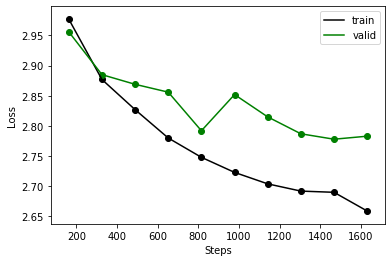

In [15]:
plotLosses(finetuned_models_path/'eval_results.txt')